In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, roc_curve, roc_auc_score

import tensorflow as tf

In [2]:
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams['axes.grid']=True
plt.rcParams["figure.figsize"] = (17,6)

# Problem Description

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

## Data Description


-  city: city this user signed up in
-  phone: primary device for this user
-  signup_date: date of account registration; in the form ‘YYYYMMDD’
-  last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
-  avg_dist: the average distance in miles per trip taken in the first 30 days after signup
-  avg_rating_by_driver: the rider’s average rating over all of their trips
-  avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
-  surge_pct: the percent of trips taken with surge multiplier > 1
-  avg_surge: The average surge multiplier over all of this user’s trips
-  trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
-  ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
-  weekday_pct: the percent of the user’s trips occurring during a weekday

In [3]:
with open('ultimate_data_challenge.json', 'r') as f:
    data = json.load(f)

riders = pd.DataFrame(data)
riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [4]:
riders.tail()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
49995,5.63,4.2,5.0,1.0,King's Landing,2014-06-05,iPhone,2014-01-25,0.0,0,False,100.0
49996,0.00,4.0,NaN,1.0,Astapor,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0
49997,3.86,5.0,5.0,1.0,Winterfell,2014-05-22,Android,2014-01-31,0.0,0,True,100.0
49998,4.58,3.5,3.0,1.0,Astapor,2014-01-15,iPhone,2014-01-14,0.0,2,False,100.0
49999,3.49,5.0,NaN,1.0,Astapor,2014-04-20,Android,2014-01-18,0.0,0,False,0.0


## Cleaning and EDA

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

In [5]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
riders.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


The dataframe has two date columns that are strings. These will need to be changed to datetime format. The columns 'phone', 'avg_rating_by_driver' and 'avg_rating_of_driver' have missing values which will need to be imputed.

In [7]:
riders['last_trip_date'][0]

'2014-06-17'

In [8]:
riders['signup_date'][0]

'2014-01-25'

In [9]:
riders['last_trip_date'] = pd.to_datetime(riders.last_trip_date)
riders['signup_date'] = pd.to_datetime(riders.signup_date)

In [10]:
print(riders['last_trip_date'][0])
print(riders['signup_date'][0])

2014-06-17 00:00:00
2014-01-25 00:00:00


In [11]:
riders['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

The last trip was on 1st July, therefore active users would have to have used the service in the month prior i.e. from 1st June to 30th June

In [12]:
percent_retained = ((riders.last_trip_date >= '2014-06-01').sum() / (riders.last_trip_date >= '2014-06-01').count()) * 100
percent_retained

37.608000000000004

About 38% of riders were active in the last month (1st June 2014 to 30th June 2014.

In [13]:
#Creating 'active' column of active riders as integer type column: 0 marks inactive rider, 1 marks active rider
riders['active'] = (riders.last_trip_date >= '2014-06-01')*1
riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [14]:
riders.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,active
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084,0.376080
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503,0.484405
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000,0.000000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,0.000000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000


In [15]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


In [16]:
#Filling in missing values in 'phone' column.
riders['phone'].fillna('MISSING', inplace = True)
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


In [17]:
#Filling in missing values in 'avg_rating_by_driver' and 'avg_rating_of_driver' columns
riders.avg_rating_by_driver.fillna(riders.avg_rating_by_driver.mean(),inplace=True)
riders.avg_rating_of_driver.fillna(riders.avg_rating_of_driver.mean(),inplace=True)

In [18]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


In [19]:
#The labels are imbalanced
riders.active.value_counts()

0    31196
1    18804
Name: active, dtype: int64

In [20]:
inactive, active = np.bincount(riders['active'])
total = inactive + active
print('Examples:\n    Total: {}\n    Active: {} ({:.2f}% of total)\n'.format(
    total, active, 100 * active / total))

Examples:
    Total: 50000
    Active: 18804 (37.61% of total)



In [21]:
riders.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [22]:
riders.phone.value_counts()

iPhone     34582
Android    15022
MISSING      396
Name: phone, dtype: int64

In [23]:
riders.ultimate_black_user.value_counts()

False    31146
True     18854
Name: ultimate_black_user, dtype: int64

## Visual EDA

### Relationships between 'active' column & non-categorical columns

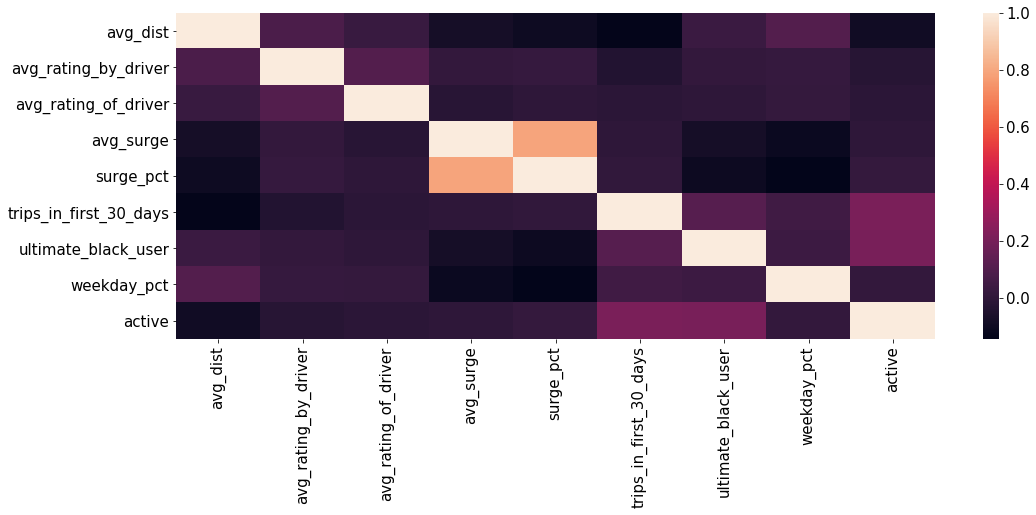

In [24]:
fig = plt.figure()
ax = plt.subplot(111)
corr = riders.corr()
ax = sns.heatmap(corr)
plt.show()

In [25]:
corr['active'].sort_values(ascending=False)

active                    1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.010829
avg_rating_by_driver     -0.026748
avg_dist                 -0.092780
Name: active, dtype: float64

The previous cells show positive correlation between whether a rider was classified 'active' or 'inactive' and whether they took a trip in their first 30 days after signing up. This is an intuitive finding since users who neglect to use a service typically have no use for it and therefore they're likely to stop using it. 

There's also a similar positive correlation between 'active' users and users of the Ultimate Black Service. Perhaps there's a quality gap between customer service provided by the Ultimate Black Service compared to regular drivers?


### Relationships between 'active' column & categorical columns: 'Cities' & 'Phones'

In [26]:
#One hot encoding of 'city' and 'phone' column to get segmentation
cities_hot = pd.get_dummies(riders['city'])
phones_hot = pd.get_dummies(riders['phone'])
riders = riders.join(cities_hot)
riders = riders.join(phones_hot)
riders.drop(['city', 'phone'], axis=1, inplace=True)
riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active,Astapor,King's Landing,Winterfell,Android,MISSING,iPhone
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,1,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,0,1,0,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,1,0,1,0,0,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,0,1,1,0,0


In [27]:
#description of the different 'city' and 'phone' segments
riders.describe().iloc[:, -7:]

,active,Astapor,King's Landing,Winterfell,Android,MISSING,iPhone
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.376080,0.330680,0.202600,0.466720,0.300440,0.007920,0.691640
std,0.484405,0.470463,0.401941,0.498896,0.458454,0.088642,0.461821
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


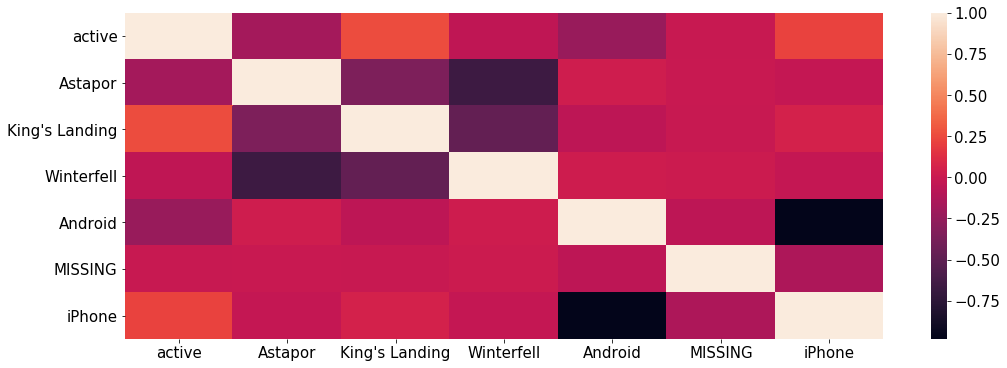

In [28]:
categoricals = riders.iloc[:,-7:]
fig = plt.figure()
ax = plt.subplot(111)
corr = categoricals.corr()
ax = sns.heatmap(corr)
plt.show()

In [29]:
corr['active'].sort_values(ascending=False)

active            1.000000
King's Landing    0.262284
iPhone            0.225244
MISSING          -0.007419
Winterfell       -0.046611
Astapor          -0.174655
Android          -0.225464
Name: active, dtype: float64

The previous cells show correlation between whether a rider was classified 'active' or 'inactive' and King's Landing as a location. This seems to suggest King's Landing is not a walkable city. There's also a similar positive correlation between 'active' users and users who signed up on an iPhone while Android users were less likely to remain 'active' users of the service. This might suggest the app user experience on iOS vs Android is different and might cause users to have differing experiences. 

In [30]:
riders['signup_date'] = riders['signup_date'].dt.strftime('%Y%m%d').astype(int)
riders['last_trip_date'] = riders['last_trip_date'].dt.strftime('%Y%m%d').astype(int)

### Relationship between 'signup_date' column and 'active' column

In [31]:
riders['signup_date'].corr(riders['active'])

-0.020210618434848206

### Relationship between 'last_trip_date' column and 'active' column

In [32]:
riders['last_trip_date'].corr(riders['active'])

0.7767221858818709

These two columns show colinearity therefore I will remove the 'last_trip_date' column from my features when modeling.

In [33]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null int64
signup_date               50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null int64
Astapor                   50000 non-null uint8
King's Landing            50000 non-null uint8
Winterfell                50000 non-null uint8
Android                   50000 non-null uint8
MISSING                   50000 non-null uint8
iPhone                    50000 non-null uint8
dtypes: bool(1), float64(6), int64(4), uint8(6)
memory usage: 4.1 MB


In [34]:
#converting the 'ultimate_black_user' column from bool to int
riders['ultimate_black_user'] = riders['ultimate_black_user'].astype(int)
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null int64
signup_date               50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
active                    50000 non-null int64
Astapor                   50000 non-null uint8
King's Landing            50000 non-null uint8
Winterfell                50000 non-null uint8
Android                   50000 non-null uint8
MISSING                   50000 non-null uint8
iPhone                    50000 non-null uint8
dtypes: float64(6), int64(5), uint8(6)
memory usage: 4.5 MB


## Predictive Modeling

2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

In [35]:
# removing 'last_trip_date' column from features because this column is highly correlated with the 'active column'
y = riders['active']
X = riders.drop(['active', 'last_trip_date'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35000, 15)
(15000, 15)
(35000,)
(15000,)


In [36]:
#tracking model scores plus AUC-Scores for final comparison
model_results = []

### Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
score = accuracy_score(y_test,y_pred)
score

0.6252666666666666

In [38]:
roc_score = roc_auc_score(y_test, y_pred)

In [39]:
model_results.append(('Logistic Regression', score, np.round(roc_score, 2)))

In [40]:
print(classification_report(y_test, y_pred, target_names=['active','inactive']))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

      active       0.63      1.00      0.77      9379
    inactive       0.00      0.00      0.00      5621

   micro avg       0.63      0.63      0.63     15000
   macro avg       0.31      0.50      0.38     15000
weighted avg       0.39      0.63      0.48     15000

[[9379    0]
 [5621    0]]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The severe imbalance in the labels caused the Logistic Regression to underperform with the weighted F1-Score being 48% despite an accuracy score of 63 %

### Tree Based Classification Models: Random Forest

In [41]:
from sklearn.metrics import classification_report, roc_auc_score,  accuracy_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [42]:
clf1 = RandomForestClassifier(n_estimators=300, max_depth = 50, max_features=5, min_samples_split=8)
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)
score = accuracy_score(y_test,y_pred)
score

0.7786666666666666

In [43]:
roc_score1 = roc_auc_score(y_test, y_pred)

In [44]:
model_results.append(('Random Forest', score, np.round(roc_score1, 2)))

In [45]:
print(classification_report(y_test, y_pred, target_names=['active','inactive']))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

      active       0.81      0.85      0.83      9379
    inactive       0.73      0.66      0.69      5621

   micro avg       0.78      0.78      0.78     15000
   macro avg       0.77      0.75      0.76     15000
weighted avg       0.78      0.78      0.78     15000

[[7985 1394]
 [1926 3695]]


The random forest outperforms the logistic regression on the same set of imbalanced data with a weighted avg F1 score of 78% and an accuracy of 78%.

### Recurrent Neural Network

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [47]:
sc = StandardScaler()
X = sc.fit_transform(X)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [48]:
X.shape

(50000, 15)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
METRICS = [ 
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),
      tf.keras.metrics.AUC(name='AUC'),
]

model = Sequential()

model.add(Dense(64, activation='relu', input_dim=15))
model.add(Dense(32, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(8, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(4, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =METRICS)

es = EarlyStopping(monitor='AUC',patience=10)

In [51]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split = 0.1, callbacks=[es], verbose =0)

In [52]:
results = model.evaluate(X_test, y_test)
results

469/469 [==============================] - 1s 2ms/step - loss: 0.5178 - Accuracy: 0.7705 - Precision: 0.7282 - Recall: 0.6182 - AUC: 0.8261


[0.5178453326225281,
 0.770466685295105,
 0.728206217288971,
 0.618217408657074,
 0.8260757327079773]

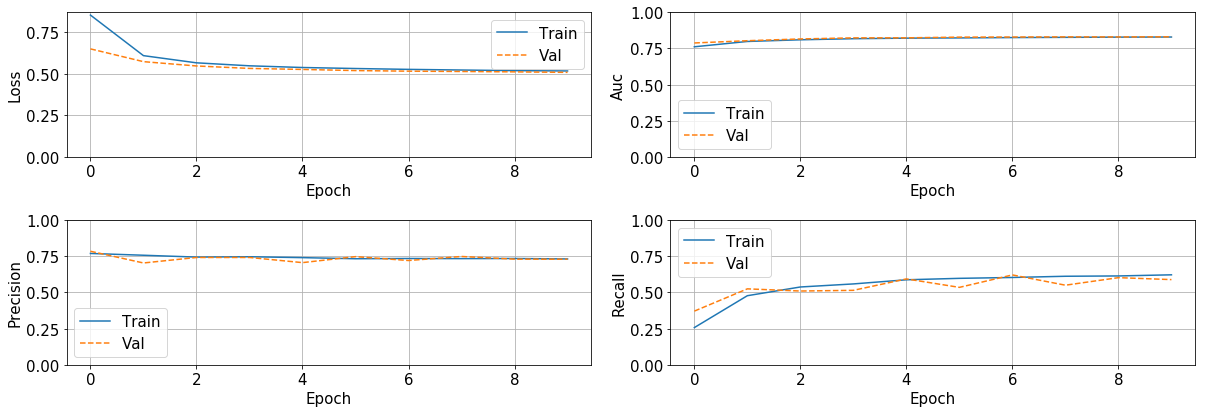

In [53]:
def plot_metrics(history):
  metrics =  ['loss', 'AUC', 'Precision', 'Recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.tight_layout()
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

In [54]:
test_predictions = model.predict(X_test)

Inactive user correctly labeled inactive (True Negatives):  8082
Inactive user incorrectly labeled active (False Positives):  1297
Active user incorrectly labeled inactive (False Negatives):  2146
Active user correctly labeled active  (True Positives):  3475
Total users:  5621


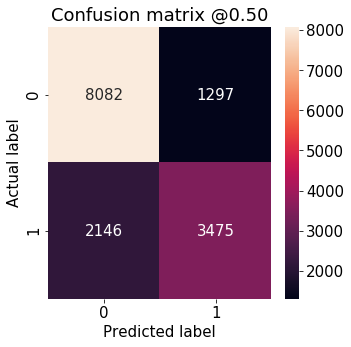

In [55]:
def plot_cm(labels, predictions, p = 0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Inactive user correctly labeled inactive (True Negatives): ', cm[0][0])
  print('Inactive user incorrectly labeled active (False Positives): ', cm[0][1])
  print('Active user incorrectly labeled inactive (False Negatives): ', cm[1][0])
  print('Active user correctly labeled active  (True Positives): ', cm[1][1])
  print('Total users: ', np.sum(cm[1]))

plot_cm(y_test, test_predictions)

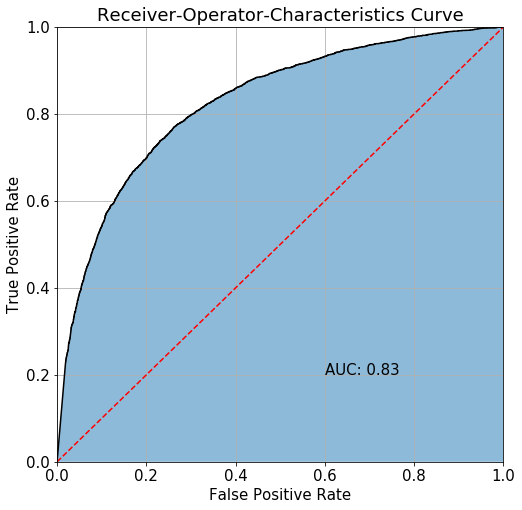

Accuracy = 77.87%, Area Under ROC Curve: 0.83


In [56]:
fpr, tpr, _ = roc_curve(y_test, test_predictions)
fig,(ax1) = plt.subplots(1,1,figsize=(8,8))

ax1.plot(fpr, tpr, 'k-')
ax1.plot([0, 1], [0, 1], 'r--')
ax1.fill_between(fpr, tpr, alpha =0.5)
ax1.axis([0,1,0,1])

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver-Operator-Characteristics Curve')

roc_score = roc_auc_score(y_test, test_predictions)
ax1.text(0.6,0.2,'AUC: {}'.format(np.round(roc_score,2)));

plt.show()

print('Accuracy = {}%, Area Under ROC Curve: {}'.format(np.round(score*100, 2), np.round(roc_score, 2)))


The RNN outperforms all prior models on the same imbalanced data with an AU-ROC Curve of 83% and an accuracy of 78%. Despite this performance, there is a caveat in that the model misclassifies a large number of riders (about 1000) as inactive whereas they are actually active riders. Given that this model performed the best, it would be worth it to resample the dataset by oversampling the imbalanced class (in this case the users marked 'active'). We could also adjust the probability threshold for classification depending on whether or not we placed more emphasis on precision vs recall. 

In [57]:
model_results.append(('RNN', score, np.round(roc_score, 2)))

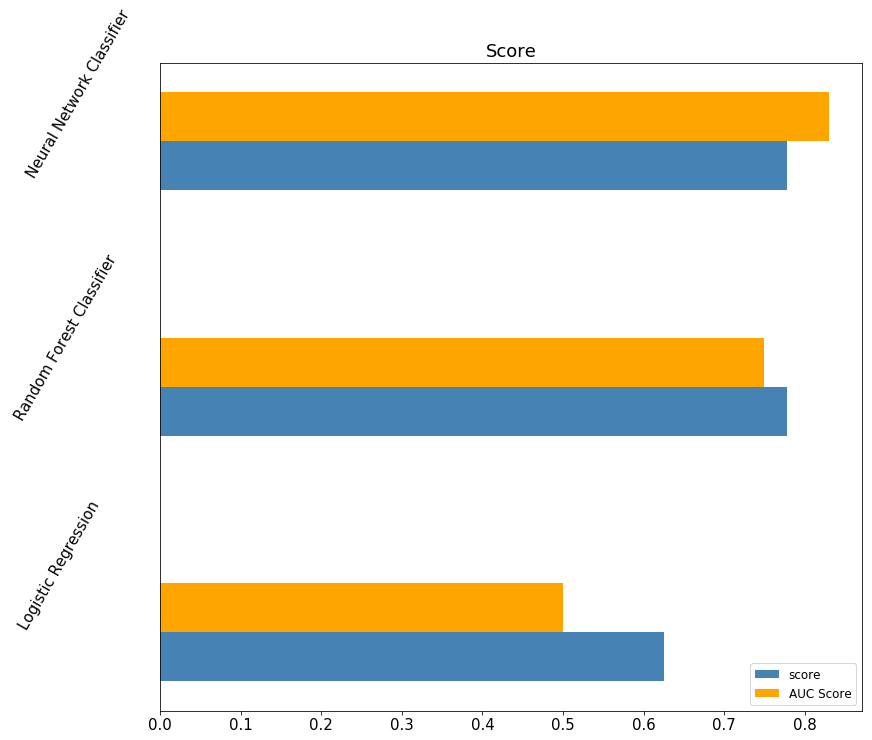

,Score,AUC Score
Classifier,,
Logistic Regression,0.625267,0.50
Random Forest,0.778667,0.75
RNN,0.778667,0.83


In [58]:
indices = np.arange(len(model_results))

results = [[x[i] for x in model_results] for i in range(3)]

clf_names, score, AUC = results

plt.figure(figsize=(15, 10))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='steelblue')
plt.barh(indices + .2, AUC, .2, label="AUC Score", color='orange')

plt.yticks(())

plt.legend(loc='best', fontsize = '12')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

clf_names = ['    Logistic Regression',
             '  Random Forest Classifier',
            '       Neural Network Classifier']
for i, c in zip(indices, clf_names):
    plt.text(-.19, i+0.6, c, rotation = 60)
plt.grid()
plt.show()

Final_df = pd.DataFrame(model_results)
Final_df.columns = ['Classifier','Score', 'AUC Score']
Final_df.set_index('Classifier',inplace = True)
Final_df

### Calculating Feature Importances: Random Forest

In [63]:
with open('ultimate_data_challenge.json', 'r') as f:
    data = json.load(f)

riders = pd.DataFrame(data)
riders.head()

riders['active'] = (riders.last_trip_date >= '2014-06-01')*1
riders.last_trip_date = pd.to_datetime(riders.last_trip_date)
riders.signup_date = pd.to_datetime(riders.signup_date)
riders['signup_date'] = riders['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100
riders['last_trip_date'] = (riders['last_trip_date'] - min(riders['last_trip_date'])).dt.days + 1 

riders.phone.fillna('MISSING', inplace=True)
riders['city'] = riders['city'].astype('category')
riders['phone'] = riders['phone'].astype('category')
riders = pd.get_dummies(riders)

In [64]:
riders.avg_rating_by_driver.fillna(riders.avg_rating_by_driver.mean(),inplace=True)
riders.avg_rating_of_driver.fillna(riders.avg_rating_of_driver.mean(),inplace=True)

In [65]:
y = riders['active']
X = riders.drop(['active', 'last_trip_date'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [66]:
clf2 = RandomForestClassifier(n_estimators=300, max_depth = 50, max_features=5, min_samples_split=8)
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
score = accuracy_score(y_test,y_pred)

Text(0.5, 1.0, 'Random Forest Feature Importance')

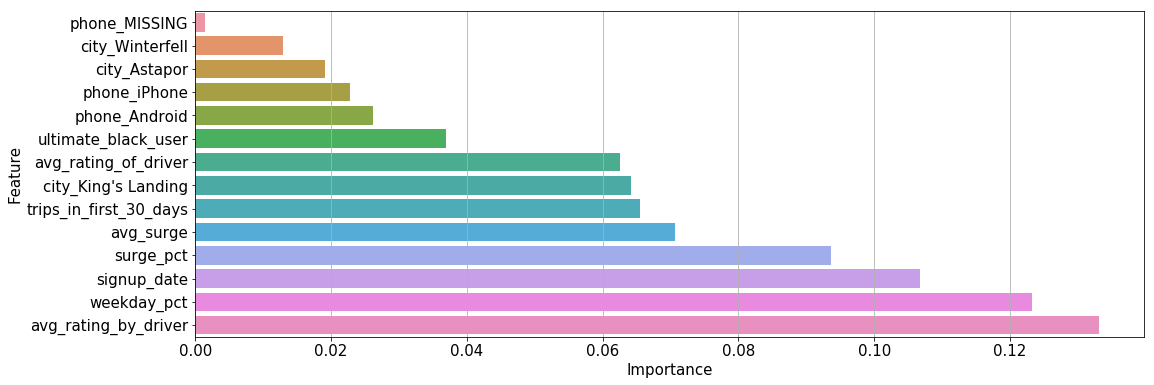

In [67]:
features_rf = pd.DataFrame({'Importance': clf2.feature_importances_})    
features_rf['Feature'] = X.columns
features_rf.sort_values(by='Importance', ascending=True, inplace=True)
features_rf = features_rf.iloc[:14]

sns.barplot(y="Feature", x="Importance", data=features_rf)
ax1.set_title('Random Forest Feature Importance')

The Random Forest highlights the top features most correlated with users remaining 'active' as 'avg_rating_by_driver', 'weekday_pct', and 'signup_date'. This is at odds with the statistical inference we conducted earlier indicating more intuitive positive correlations with 'iPhone' use, location of 'King's Landing' and whether or not the rider was a 'ultimate_black_user'. Users who use the service on the weekends are most likely to be one time users who might only use it when inconvenienced vs weekday users who might be professionals who use the service more days per week. 

# Recommendations for Ultimate

1. Introduce incentives for users to ride on weekdays and during surge hours
2. Improve driver and rider satisfaction to ensure multiple trips